In [1]:
import numpy as np
import scipy.stats as si
from scipy.sparse import diags
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# Due to runnning out of time, my codes are not the neatest.

# Change the T in the cell below to match what you need cuz the functions left_term() and right_term() will be using dt from here

In [2]:
# Grid parameters
r_min, r_max = 0.03, 0.20
c_min, c_max = -0.04, 0.04
s_min , s_max = 0, 250  # check that 250 is a good number
L, N, M = 100 , 1000, 100  # N = 1000, M = 100
D = 0.04
# Market parameters
sigma, T = 0.15, 5

# Setup of grids
dt = T/N
dr = (r_max - r_min)/M
ds = (s_max - s_min)/M

#r_i
r = np.linspace(r_min, r_max, M+1)
r_i = np.array([r[i] * np.ones(M+1) for i in range(M+1)])

#s_k
s = np.linspace(s_min, s_max, M+1)
s_k = np.array([s for i in range(M+1)])

t = np.linspace(0, T, N+1)          #t_j

In [ ]:
# Satisfy the CFL condition -> Stable... Not sure if the condition still the same?
print(c_max * dt <= dr)

True


\begin{align}
\frac{U^{j-1}_{ik}-U^{j}_{ik}}{Δt}=\frac{\sigma^2 s_k^2}{2}\frac{U^{j}_{i(k+1)}-2U^j_{ik}+U^j_{i(k-1)}}{\Delta s^2} +(r_i-D)s_k \frac{U^{j}_{i(k+1)}-U^j_{i(k-1)}}{2\Delta s} +c\left(U_{r}\right) \frac{1}{\Delta r}\left\{\begin{array}{ll}
U_{(i+1)k}^{j}-U_{ik}^{j} & \text { if } c>0 \\
U_{ik}^{j}-U_{(i-1)k}^{j} & \text { if } c\leq0
\end{array}\right\}-r_{i} U_{ik}^{j}
\end{align}

\begin{align}
U^{j-1}_{ik}=\left[1- \frac{\sigma^2 \Delta t s_k^2}{Δs^2} - \Delta tr_{i}  \right]U^j_{ik} + \left[\frac{\sigma^2 \Delta t s_k^2}{2Δs^2} + \frac{(r_i-D)S_kΔt}{2Δs} \right]U^j_{i(k+1)} + \left[\frac{\sigma^2 \Delta t s_k^2}{2Δs^2} - \frac{(r_i-D)S_kΔt}{2Δs} \right]U^j_{i(k-1)} +c\left(U_{r}\right) \frac{Δt}{\Delta r}\left\{\begin{array}{ll}
U_{(i+1)k}^{j}-U_{ik}^{j} & \text { if } c>0 \\
U_{ik}^{j}-U_{(i-1)k}^{j} & \text { if } c\leq0
\end{array}\right\}
\end{align}

, where at $s_min$,

$$
 U_{i0}^{j-1}=\left(1-r_i \Delta t\right) U_{i0}^{j}+c\left(r, V_{r}\right) \frac{\Delta t}{\Delta r} \begin{cases}U_{(i+1)0}^{j}-U_{i0}^{j} & \text { if } c>0  \\ U_{i0}^{j}-U_{(i-1)0}^{j} & \text { if } c \leq 0 .\end{cases}
$$

Description for $c(r,V_r)$ is complicated. In summary,

1. Check if Minima($
U_{i}^{j} \leq U_{i-1}^{j} \text { and } U_{i}^{j} \leq U_{i+1}^{j}
$), $c\left(r, V_{r}\right)=0.$
2. eliff Maxima($
U_{i}^{j} \geq U_{i-1}^{j} \text { and } U_{i}^{j} \geq U_{i+1}^{j}
$), $$
c\left(r, V_{r}\right)= \begin{cases}c_{max} & \text { if } c_{max}\left(U_{i+1}^{j}-U_{i}^{j}\right) \leq c_{min}\left(U_{i}^{j}-U_{i-1}^{j}\right) \\ c_{min} & \text { if } c_{max}\left(U_{i+1}^{j}-U_{i}^{j}\right)>c_{min}\left(U_{i}^{j}-U_{i-1}^{j}\right)\end{cases}
$$
3. else: $$ c\left(r, V_{r}\right)= \begin{cases}c_{max}\left(r_{min}+i \Delta r\right) & \text { if } U_{i+1}^{j}-U_{i-1}^{j}<0 \\ c_{min}\left(r_{min}+i \Delta r\right) & \text { if } U_{i+1}^{j}-U_{i-1}^{j}>0\end{cases}.$$

Address the boundary values appropriately

In [ ]:
def c(u_ikj, M):
  """
  Compute the c(r, V_r) 2D array given (u_ik) 2D array at each t_j
  """

  u_minus_1 = u_ikj[0:-2, :]
  u = u_ikj[1:-1, :]
  u_plus_1 = u_ikj[2:M+1, :]

  # initialise the c matrix called c_int, and modify the boundary values
  c_ans = np.zeros((M+1, M+1))
  c_ans[0,:] = np.where( (u_ikj[1,:] - u_ikj[0,:])/dr < 0, c_max, 0)
  c_ans[-1,:] = np.where( (u_ikj[-1,:] - u_ikj[-2,:])/dr > 0, c_min, 0)

  # Numpy version of : If Minima->0, elif maxima either c_max or c_min, else either c_max or c_min

  c = np.where((u_minus_1>u) & (u<u_plus_1),
               0,
               np.where((u_minus_1<u) & (u>u_plus_1) & (c_max*(u_plus_1-u)<= c_min*(u-u_minus_1)),
                        c_max ,
                        np.where((u_minus_1<u) & (u>u_plus_1) & (c_max*(u_plus_1-u)> c_min*(u-u_minus_1)),
                                 c_min ,
                                 np.where(u_plus_1-u_minus_1 < 0 ,
                                          c_max ,
                                          c_min))))
  c_ans[1:-1, :] = c

  return c_ans

def right_term(u_ikj, c, M):

   """
   Compute the RHS of the main iterative equation
   """

   u_minus_1 = u_ikj[0:-2, :]
   u = u_ikj[1:-1, :]
   u_plus_1 = u_ikj[2:M+1, :]

   # Upwind scheme term

   upwind = np.zeros((M+1,M+1))
   # Modify the boundaries term
   upwind[0,:] = u_ikj[1,:]-u_ikj[0,:]
   upwind[-1,:] = u_ikj[-1,:]-u_ikj[-2,:]

   # The rest of the upwind term
   upwind[1:-1,:] = np.where(c(u_ikj, M)[1:-1,:] > 0, u_plus_1 - u, u - u_minus_1 )


   # Compute the right hand side of the equation
   right_term = (dt/dr) * np.multiply(c(u_ikj,M), upwind)

   return right_term


def left_term(u_ikj, M):

   """
   Compute the problematic term of the LHS (sum of three terms) of the main iterative equation
   """

   u_minus_1 = u_ikj[:, 0:-2]
   u = u_ikj[:, 1:-1]
   u_plus_1 = u_ikj[:, 2:M+1]


   # Initialise the terms
   first_term, second_term, third_term  = np.zeros((M+1,M+1)), np.zeros((M+1,M+1)), np.zeros((M+1,M+1))

   # Modify the boundaries term
   # Same value as normal bonds at s_min and conversion value (n*s_max) at s_max
   first_term[:, 0] = np.multiply((1 - r*dt), u_ikj[:,0]) # at s_min is non-convertible bond
   first_term[:, -1] = 0.01*s_k[:,-1]  # at s_max is 0.01* s_max

   # The rest
   first_term[:, 1:-1] = np.multiply(1-sigma**2 *dt /(ds**2) * np.multiply(s_k[:, 1:-1],s_k[:, 1:-1])-dt*r_i[:, 1:-1], u)
   second_term[:, 1:-1] = np.multiply(sigma**2 *dt /(2* ds**2) * np.multiply(s_k[:, 1:-1],s_k[:, 1:-1]) + (r_i[:, 1:-1]-D)*s_k[:, 1:-1]*dt/(2*ds) , u_plus_1)
   third_term[:, 1:-1] = np.multiply(sigma**2 *dt /(2* ds**2) * np.multiply(s_k[:, 1:-1],s_k[:, 1:-1]) - (r_i[:, 1:-1]-D)*s_k[:, 1:-1]*dt/(2*ds), u_minus_1)

   return first_term + second_term + third_term


The underlying asset has current value 100, the volatility is $15 \%$ and the dividend yield is $4 \%$. Note that we are not questioning the accuracy of these asset price parameters.

We value a convertible bond with a maturity of 25th November 2001 (where today is 14th May 1998)-> 3.5 years. The bond has principal 1, can be converted into 0.01 of the asset and pays a coupon of $3 \%$ every six months until expiry. The spot short-term interest rate is $7 \%$.


In [3]:
# miscellaneous functions

def index_time_conv(list_t, T):
  ans = []
  dt = T/N
  for i in list_t:
    ans.append(int(round(i/dt)))

  return ans

def index_rate_conv(r):

  dr = (r_max - r_min)/M

  return round((r-r_min)/dr)

def index_price_conv(s):
  ds = (s_max - s_min)/M

  return round((s-s_min)/ds)

T=3.57
dt = T/N
coupon_times = [0.5,1,1.5,2,2.5,3,3.5]
maturity_times = [0.5,1,2,3,5,7,4]  # for hedging later
print(index_time_conv(maturity_times, T)[:-1])
print(index_time_conv(coupon_times, T))

# r = 0.06
# print(index_rate_conv(r))

[140, 280, 560, 840, 1401, 1961]
[140, 280, 420, 560, 700, 840, 980]


\begin{align}
U^{j-1}_{ik}=\left[1- \frac{\sigma^2 \Delta t s_k^2}{Δs^2} - \Delta tr_{i}  \right]U^j_{ik} + \left[\frac{\sigma^2 \Delta t s_k^2}{2Δs^2} + \frac{(r_i-D)S_kΔt}{2Δs} \right]U^j_{i(k+1)} + \left[\frac{\sigma^2 \Delta t s_k^2}{2Δs^2} - \frac{(r_i-D)S_kΔt}{2Δs} \right]U^j_{i(k-1)} +c\left(U_{r}\right) \frac{Δt}{\Delta r}\left\{\begin{array}{ll}
U_{(i+1)k}^{j}-U_{ik}^{j} & \text { if } c>0 \\
U_{ik}^{j}-U_{(i-1)k}^{j} & \text { if } c\leq0
\end{array}\right\}
\end{align}


Constriants:

\begin{equation}    
    V(S, r, t) \geq n S
\end{equation}
at all times that conversion is permitted along with continuity of $V$ and $V_{S}$.
The final condition at maturity of the bond, $T$, is that the bond value is equal to the principal, assumed to be 1 , plus the last coupon
$$
V(S, r, T)=1+c_{T}
$$

Across each coupon date, $t_{i}$, the bond falls by the amount of the coupon, and,
$$
V\left(S, r, t_{i}^{-}\right)=V\left(S, r, t_{i}^{+}\right)+c_{i}
$$


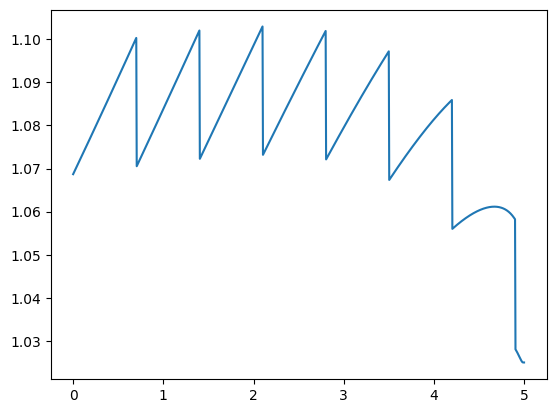

In [ ]:
# Payoff for CB with principle of 1
u_vec = np.ones((M+1,M+1))


# PDE solver for worst and best case scenarios
def pde_solver(u, c, T, worst = True):

  coupon = 0.03
  s = np.linspace(s_min, s_max, M+1)
  r = np.linspace(r_min, r_max, M+1)

  s_k = np.array([s for i in range(M+1)])
  r_i = np.array([r[i] * np.ones(M+1) for i in range(M+1)])


  t = np.linspace(0, T, N+1)
  dt = T/N

  # For best case
  if worst == False:
    u = -u
    coupon = -0.03

  # For storing the values at different times, u_ikj for r_i, s_k, t_j
  U = np.zeros((M+1, M+1, N+1))

  #Coupon times
  time_index = index_time_conv(coupon_times, T)
  for x in time_index:
    U[:,:,x] = coupon*np.ones((M+1, M+1))

  # principal at maturity
  U[:,:,N] = u
  if worst:
    U[:,:,N] = np.where(U[:,:,N] < 0.01*s_k, 0.01*s_k, U[:,:,N])
  else:
    U[:,:,N] = np.where(U[:,:,N] > -0.01*s_k, -0.01*s_k, U[:,:,N])

  #Backward induction
  for j in reversed(range(N)):

    U[:,:,j] += left_term(U[:,:,j+1], M) +right_term(U[:,:,j+1], c, M)  # gotta add the payoff from the hedging instrument here I think
    if worst:
      U[:,:,j] = np.where(U[:,:,j] < 0.01*s_k, 0.01*s_k, U[:,:,j])
    else:
      U[:,:,j] = np.where(U[:,:,j] > -0.01*s_k, -0.01*s_k, U[:,:,j])

  return U if worst else -U

#Bear in mind when printing that U_ikj[i,k,j]
U_ikj = pde_solver(u_vec, c, T)
U_ikj_best = pde_solver(u_vec, c, T, worst = False)

# T = 3.57
# t = np.linspace(0, T, N+1)

L, N, M = 100 , 1000, 100  # N = 1000, M = 100
r_t0, s_t0 = 0.07, 100
i = index_rate_conv(r_t0)
k = index_price_conv(s_t0)

plt.plot(t, pde_solver(u_vec, c, 3.57)[25,41,:])

In [ ]:
# Show the price of unhedged convertible bond
r_t0, s_t0 = 0.07, 100
i = index_rate_conv(r_t0)
k = index_price_conv(s_t0)

print(U_ikj[i+1,k+1,0]) # epstein quotes 1.072
print(U_ikj_best[i+1,k+1,0])  # epstein quotes 1.191
#print(U_ikj[0,:,0])

# decided to represent the value at i+1, k+1 throughout

1.0686984008776907
1.1777207381037649


# Convertible value
Under log normal price, Could do Mente Carlo

V = E[max(discounted cashflow, price)]

But doesn't work out so will do Finite Diff. Method instead.

The discretised equation of the PDE for convertible bond under fixed interest rate is:

\begin{align}
U^{j-1}_{ik}=\left[1- \frac{\sigma^2 \Delta t s_k^2}{Δs^2} - \Delta tr_{i}  \right]U^j_{ik} + \left[\frac{\sigma^2 \Delta t s_k^2}{2Δs^2} + \frac{(r_i-D)S_kΔt}{2Δs} \right]U^j_{i(k+1)} + \left[\frac{\sigma^2 \Delta t s_k^2}{2Δs^2} - \frac{(r_i-D)S_kΔt}{2Δs} \right]U^j_{i(k-1)}
\end{align}


In [ ]:
# Payoff for CB with principle of 1
u_vec = np.ones((M+1,M+1))


# Convertible solver for constant r
def convertible_solver(u, c, T):

  coupon = 0.03
  s = np.linspace(s_min, s_max, M+1)
  r = np.linspace(r_min, r_max, M+1)

  s_k = np.array([s for i in range(M+1)])
  r_i = np.array([r[i] * np.ones(M+1) for i in range(M+1)])


  t = np.linspace(0, T, N+1)
  dt = T/N

  # For storing the values at different times, u_ikj for r_i, s_k, t_j
  U = np.zeros((M+1, M+1, N+1))

  # Coupon times
  time_index = index_time_conv(coupon_times, T)
  for x in time_index:
    U[:,:,x] = coupon*np.ones((M+1, M+1))

  # principal at maturity
  U[:,:,N] = u
  U[:,:,N] = np.where(U[:,:,N] < 0.01*s_k, 0.01*s_k, U[:,:,N])

  #Backward induction
  for j in reversed(range(N)):
    U[:,:,j] += left_term(U[:,:,j+1], M)
    U[:,:,j] = np.where(U[:,:,j] < 0.01*s_k, 0.01*s_k, U[:,:,j])

  return U

# Bear in mind when printing that U_ikj[i,k,j]
convertible_ikj = convertible_solver(u_vec, c, T)

r_t0, s_t0 = 0.07, 100
i = index_rate_conv(r_t0)
k = index_price_conv(s_t0)

print(convertible_ikj[i+1,k+1,0]) # convertible value at r =0.07


1.119672671175758


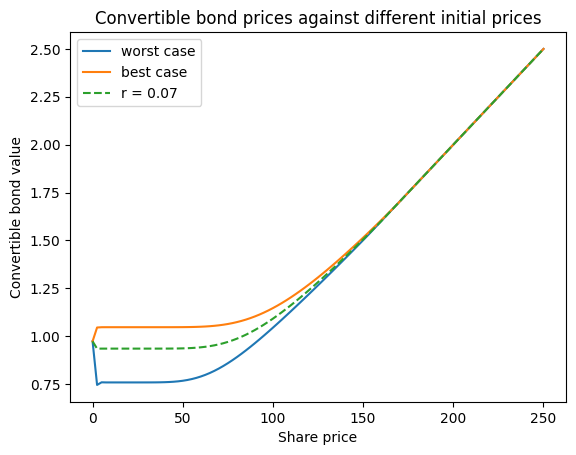

In [ ]:
# Plot some stuff to show what's going on
s = np.linspace(s_min, s_max, M+1)

plt.plot(s , U_ikj[i+1,:,0])
plt.plot(s , U_ikj_best[i+1,:,0])
plt.plot(s, convertible_ikj[i+1,:,0], linestyle= '--')    # kink at the end due to boundary problem (nature of pde solver) alright we don't care about this region anyway
plt.title('Convertible bond prices against different initial prices')
plt.xlabel('Share price')
plt.ylabel('Convertible bond value')
plt.legend(['worst case','best case','r = 0.07'])

plt.show()
#plt.savefig('convertible_fixed_r.png')
# print(convertible_ikj[i,:,0])


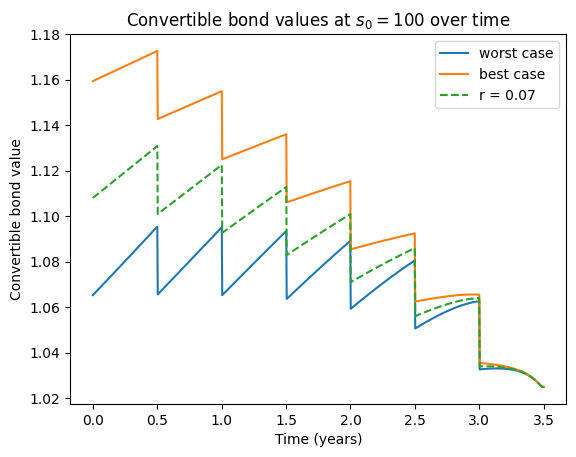

In [ ]:
# Plot some stuff to show what's going on
t = np.linspace(0, T, N+1)

plt.plot(t , U_ikj[i+1,k+1,:])
plt.plot(t , U_ikj_best[i+1,k+1,:])
plt.plot(t, convertible_ikj[i+1,k+1,:], linestyle= '--')    # kink at the end due to boundary problem (nature of pde solver) alright we don't care about this region anyway
plt.title('Convertible bond values at $s_0 = 100$ over time')
plt.xlabel('Time (years)')
plt.ylabel('Convertible bond value')
plt.legend(['worst case','best case','r = 0.07'])

plt.show()
#plt.savefig('convertible_fixed_r_2.png')
# print(convertible_ikj[i,:,0])

## Hedging convertible portfolio

\begin{align*}
&\Pi_{0}(S, r, t) = \text{the hedging instruments} \\
&\Pi_{1}(S, r, t)= \text{the hedged convertible bond without the conversion option}
\end{align*}

Then,

$$
\Pi_{1}(S, r, t) \geq n S+\Pi_{0}(S, r, t)
$$


In [4]:
coupon_times = [0.5,1,1.5,2,2.5,3,3.5]
maturity_times = [0.5,1,2,5,3.57]  # the last element for the main bond; otherwise, hedging bonds
yields = np.array([0.07447,0.07016,0.06631,0.06224])
market_prices = np.exp(- np.multiply(yields, maturity_times[:-1]))
print(market_prices)

r_t0, s_t0 = 0.07, 100
i = index_rate_conv(r_t0)
k = index_price_conv(s_t0)

[0.9634497  0.93224465 0.87579783 0.73256735]


In [5]:
def c(u_ikj, M):
  """
  Compute the c(r, V_r) 2D array given (u_ik) 2D array at each t_j
  """

  u_minus_1 = u_ikj[0:-2, :]
  u = u_ikj[1:-1, :]
  u_plus_1 = u_ikj[2:M+1, :]

  # initialise the c matrix called c_int, and modify the boundary values
  c_ans = np.zeros((M+1, M+1))
  c_ans[0,:] = np.where( (u_ikj[1,:] - u_ikj[0,:])/dr < 0, c_max, 0)
  c_ans[-1,:] = np.where( (u_ikj[-1,:] - u_ikj[-2,:])/dr > 0, c_min, 0)

  # Numpy version of : If Minima->0, elif maxima either c_max or c_min, else either c_max or c_min

  c = np.where((u_minus_1>u) & (u<u_plus_1),
               0,
               np.where((u_minus_1<u) & (u>u_plus_1) & (c_max*(u_plus_1-u)<= c_min*(u-u_minus_1)),
                        c_max ,
                        np.where((u_minus_1<u) & (u>u_plus_1) & (c_max*(u_plus_1-u)> c_min*(u-u_minus_1)),
                                 c_min ,
                                 np.where(u_plus_1-u_minus_1 < 0 ,
                                          c_max ,
                                          c_min))))
  c_ans[1:-1, :] = c

  return c_ans

def right_term(u_ikj, c, M, T):

   """
   Compute the RHS of the main iterative equation
   """

   u_minus_1 = u_ikj[0:-2, :]
   u = u_ikj[1:-1, :]
   u_plus_1 = u_ikj[2:M+1, :]

   dt = T/N
   # Upwind scheme term

   upwind = np.zeros((M+1,M+1))
   # Modify the boundaries term
   upwind[0,:] = u_ikj[1,:]-u_ikj[0,:]
   upwind[-1,:] = u_ikj[-1,:]-u_ikj[-2,:]

   # The rest of the upwind term
   upwind[1:-1,:] = np.where(c(u_ikj, M)[1:-1,:] > 0, u_plus_1 - u, u - u_minus_1 )


   # Compute the right hand side of the equation
   right_term = (dt/dr) * np.multiply(c(u_ikj,M), upwind)

   return right_term


def left_term(u_ikj, M, T):

   """
   Compute the problematic term of the LHS (sum of three terms) of the main iterative equation
   """

   u_minus_1 = u_ikj[:, 0:-2]
   u = u_ikj[:, 1:-1]
   u_plus_1 = u_ikj[:, 2:M+1]

   dt = T/N

   # Initialise the terms
   first_term, second_term, third_term  = np.zeros((M+1,M+1)), np.zeros((M+1,M+1)), np.zeros((M+1,M+1))

   # Modify the boundaries term
   # Same value as normal bonds at s_min and conversion value (n*s_max) at s_max
   first_term[:, 0] = np.multiply((1 - r*dt), u_ikj[:,0]) # at s_min is non-convertible bond
   first_term[:, -1] = 0.01*s_k[:,-1]  # at s_max is 0.01* s_max

   # The rest
   first_term[:, 1:-1] = np.multiply(1-sigma**2 *dt /(ds**2) * np.multiply(s_k[:, 1:-1],s_k[:, 1:-1])-dt*r_i[:, 1:-1], u)
   second_term[:, 1:-1] = np.multiply(sigma**2 *dt /(2* ds**2) * np.multiply(s_k[:, 1:-1],s_k[:, 1:-1]) + (r_i[:, 1:-1]-D)*s_k[:, 1:-1]*dt/(2*ds) , u_plus_1)
   third_term[:, 1:-1] = np.multiply(sigma**2 *dt /(2* ds**2) * np.multiply(s_k[:, 1:-1],s_k[:, 1:-1]) - (r_i[:, 1:-1]-D)*s_k[:, 1:-1]*dt/(2*ds), u_minus_1)

   return first_term + second_term + third_term

In [6]:
# write the hedging function: checked to be correct
#pi0 = lambdas of all the hedging instruments

u_vec_pi0 = np.zeros(M+1) # no principal at maturity
T = 5
t = np.linspace(0, T, N+1)
maturity_times = [0.5,1,2,5,3.57]  # the last element for the main bond; otherwise, hedging bonds
yields = np.array([0.07447,0.07016,0.06631,0.06224])
market_prices = np.exp(- np.multiply(yields, maturity_times[:-1]))

dr = (r_max - r_min)/M

# PDE solver for worst and best case scenarios for Pi_0 (just hedging instruments first)

def pi0_solver_hedge(u, c, T,lambs , worst = True):

  r = np.linspace(r_min, r_max, M+1)
  r_i = np.array([r[i] * np.ones(M+1) for i in range(M+1)])

  t = np.linspace(0, T, N+1)
  dt = T/N

  # For best case
  if worst == False:
    u = -u
    lambs = -lambs

  # For storing the values at different times
  U = np.zeros((M+1, M+1, N+1))
  # Adding the payoff
  time_index = index_time_conv(maturity_times, T)

  # Adding the hedging instrument fixed cash flow (dependent on lamb value), all ZCBs
  for i in range(len(lambs)):
    U[:,:,time_index[i]] = lambs[i]* np.ones((M+1,M+1))

  #Backward induction
  for j in reversed(range(N)):
    left_term = np.multiply((1 - r_i*dt), U[:,:,j+1])
    U[:,:,j] += left_term + right_term(U[:,:,j+1], c, M, T)

  return U if worst else -U

Lambs = np.array([0.283,0.053,-0.421,-0.290]) #lambdas in the literature (our lambdas should be in this area)

#plt.plot(t, pi0_solver_hedge(u_vec_pi0, c, 5,lambs)[i+1,k+1,:]) #looks right

# For quick reference
pi0_ikj = pi0_solver_hedge(u_vec_pi0, c , 5,Lambs)
pi0_ikj_best = pi0_solver_hedge(u_vec_pi0, c, 5,Lambs, worst = False)

# print(pi0_ikj[i+1][k+1][0]) #-0.30132

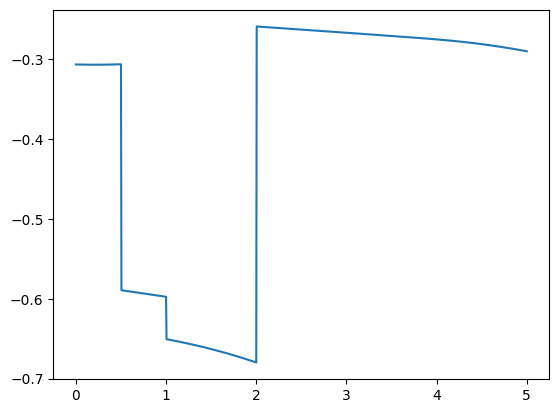

In [7]:
T = 5
t = np.linspace(0, T, N+1)
# check = ns + pi0_ikj

plt.plot(t, pi0_ikj[i+1,k+1,:])
#plt.plot(t, pi0_solver_hedge(u_vec_pi0, c , 5, m,n,np.array([0,0,0,0]))[i+1,k+1,:])
# plt.plot(t, check[i+1,k+1,:])
#plt.legend(['worst case','no bonds'])
plt.show()

In [8]:
# create ns_ikj array for convertible check
s = np.linspace(s_min, s_max, M+1)
ns_j = 0.01 * np.array([s for i in range(M+1)])
ns = np.zeros((M+1,M+1, N+1))
for j in range(N+1):
  ns[:,:,j] = ns_j

1.0641224800984506


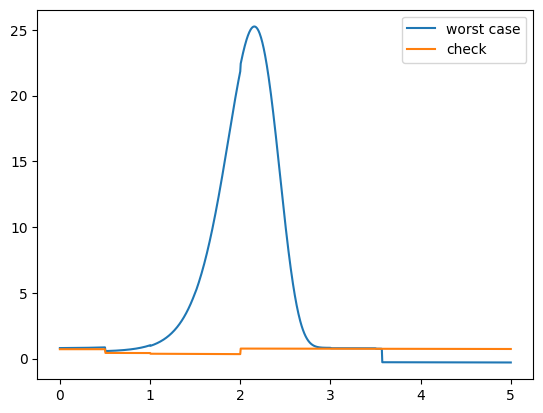

In [9]:
# Wait for the Check : the graph below look wrong, gotta fix it before tmr night

# Principle for CB with principle of 1
u_vec_pi1 = np.ones((M+1,M+1))

# PDE solver for worst and best case scenarios
# Comparing convertible values with best/worst case of hedging instruments (pi0) + conversion stocks

def pi1_solver_hedge(u, c, T,lambs, worst = True):

  coupon = 0.03

  # For best case
  if worst == False:
    u = -u
    coupon = -0.03
    lambs = -lambs
    check = ns + pi0_solver_hedge(u_vec_pi0, c, 5,lambs, worst = False)

  else:
    check = ns + pi0_solver_hedge(u_vec_pi0, c, 5,lambs)

  # For storing the values at different times, u_ikj for r_i, s_k, t_j
  U = np.zeros((M+1, M+1, N+1))

  #Coupon times
  time_index = index_time_conv(coupon_times, T)
  for x in time_index:
    U[:,:,x] = coupon*np.ones((M+1, M+1))

  # Adding the hedging instruments
  time_index2 = index_time_conv(maturity_times, T)

  # Adding the hedging instrument fixed cash flow (dependent on lamb value), all ZCBs
  for i in range(len(lambs)):
    U[:,:,time_index2[i]] = lambs[i]* np.ones((M+1,M+1))

  # principal at maturity of convertible bond
  U[:,:,time_index2[-1]] = u

  #Backward induction
  for j in reversed(range(N)):

    U[:,:,j] += left_term(U[:,:,j+1], M,T) +right_term(U[:,:,j+1], c, M,T)  # gotta add the payoff from the hedging instrument here I think

    if worst and j<time_index2[-1]:
      U[:,:,j] = np.where(U[:,:,j] < check[:,:,j], check[:,:,j], U[:,:,j])
    elif not worst and j<time_index2[-1]:
      U[:,:,j] = np.where(U[:,:,j] > -check[:,:,j],-check[:,:,j], U[:,:,j])

  return U if worst else -U

T = 5
t = np.linspace(0, T, N+1)
check = ns + pi0_ikj

plt.plot(t, pi1_solver_hedge(u_vec_pi1, c, 5,Lambs)[i+1,k+1,:]) #supposed to get 1.112 at t_0 for the hedged convertible worst case value
plt.plot(t, check[i+1,k+1,:] )
plt.legend(['worst case','check'])

# Bear in mind when printing that U_ikj[i,k,j]
pi1_ikj = pi1_solver_hedge(u_vec_pi1, c, 5,Lambs)
#pi1_ikj_best = pi1_solver_hedge(u_vec_pi1, c, 5,lambs, worst = False)


print(pi1_ikj[i+1,k+1,0]- np.dot(Lambs, market_prices))   # should be around 1.112
#print(pi1_ikj_best[i+1,k+1,0]- np.dot(lambs_best, market_prices)) # should be around 1.191

In [ ]:
print(pi1_solver_hedge(u_vec_pi1, c, 5,Lambs)[i+1:i+4,k+1:k+4,0]- np.dot(Lambs, market_prices)) # last resort if finding lambdas is too much

[[1.06412248 1.08701276 1.11181844]
 [1.06235754 1.08420001 1.10740139]
 [1.0612845  1.08247522 1.10466743]]


In [ ]:
time_index2 = index_time_conv(maturity_times, 5)
print(time_index2)

[100, 200, 400, 1000, 714]


# To minimize mistakes, I think I've gotta separate the pure hedging period (T = 3.57-5) from the $\Pi_1$ portfolio period (0-3.75)

In [ ]:
r_t0, s_t0 = 0.07, 100
i = index_rate_conv(r_t0)
k = index_price_conv(s_t0)

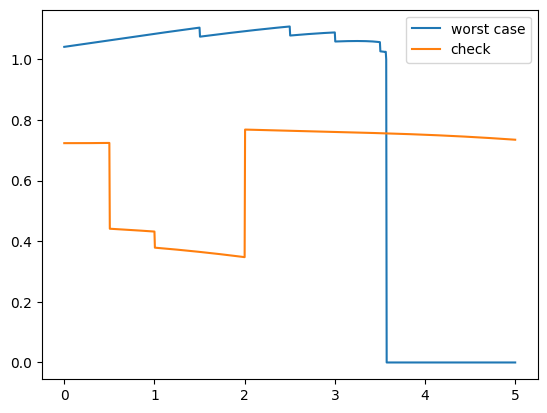

In [ ]:
# Check why I don't get the result
# Comparing convertible values with best/worst case of hedging instruments (pi0) + conversion stocks

# Payoff for CB with principle of 1
u_vec_pi1 = np.ones((M+1,M+1))

# code the arrays of time stamp from 0-3.57 and 3.57-5 years
index_1 = np.arange(714)        # 0-713
index_2 = np.arange(1000)[714:] # 714-999

def pi1_solver_hedge(u, c, T,lambs, worst = True):

  coupon = 0.03

  # For best case
  if worst == False:
    u = -u
    coupon = -0.03
    lambs = -lambs
    check = ns + pi0_solver_hedge(u_vec_pi0, c, T,lambs, worst = False)
    #check = ns + pi0_ikj_best

  else:
    check = ns + pi0_solver_hedge(u_vec_pi0, c, T,lambs)
    #check = ns + pi0_ikj

  # For storing the values at different times, u_ikj for r_i, s_k, t_j
  U = np.zeros((M+1, M+1, N+1))

  #Coupon times
  time_index = index_time_conv(coupon_times, T)
  for x in time_index:
    U[:,:,x] = coupon*np.ones((M+1, M+1))

  # Adding the hedging instruments
  time_index2 = index_time_conv(maturity_times, T)

  # Adding the hedging instrument fixed cash flow (dependent on lamb value), all ZCBs
  for y in range(len(lambs)):
    U[:,:,time_index2[y]] = lambs[y]* np.ones((M+1,M+1))

  # principal at maturity of convertible bond
  U[:,:,time_index2[-1]] = u

  #Backward induction

  for j in reversed(index_2):
    left_term_instruments = np.multiply((1 - r_i*dt), U[:,:,j+1])
    U[:,:,j] += left_term_instruments + right_term(U[:,:,j+1], c, M)

  for j in reversed(index_1):

    U[:,:,j] += left_term(U[:,:,j+1], M) +right_term(U[:,:,j+1], c, M)

    if worst :
      U[:,:,j] = np.where(U[:,:,j] < check[:,:,j], check[:,:,j], U[:,:,j])
    else:
      U[:,:,j] = np.where(U[:,:,j] > -check[:,:,j],-check[:,:,j], U[:,:,j])

  return U if worst else -U

T = 5
t = np.linspace(0, T, N+1)
check = ns + pi0_ikj

plt.plot(t, pi1_solver_hedge(u_vec_pi1, c, T,np.array([0,  0, -0, -0]))[i+1,k+1,:])
plt.plot(t, check[i+1,k+1,:])
plt.legend(['worst case','check'])
plt.show()

In [ ]:
print(pi1_solver_hedge(u_vec_pi1, c, T,lambs)[i+1,k+1,0] - np.dot(lambs, market_prices))
lambs_worst = np.array([0,  0, -0, -0]) # values are weird. Run again fresh!
print(pi1_solver_hedge(u_vec_pi1, c, T,lambs_worst)[i+1,k+1,0] - np.dot(lambs, market_prices))    # from using their lambdas which might be different from ours

1.041272339008524
1.3005210755604928


In [ ]:
print(lambs)

[ 0.283  0.053 -0.421 -0.29 ]


In [ ]:
lambs_best = np.array([-1.769e-02, -2.215e-02, -3.413e-02,  2.156e-01])

print(pi1_solver_hedge(u_vec_pi1, c, T,lambs, worst = False)[i+1,k+1,0] - np.dot(lambs, market_prices)) # nope! but I guess Epstein also didn't get it?

2.2358628211365033


In [ ]:
# Get the assembled function for evaluating hedged convertible values as a function of lambda
# minimiser and maximiser


def min_hedged_convertible(lambs):
  return pi1_solver_hedge(u_vec_pi1, c, 5,lambs, worst = False)[i+1,k+1,0] - np.dot(lambs, market_prices)

def max_hedged_convertible(lambs):
  return -pi1_solver_hedge(u_vec_pi1, c, 5,lambs)[i+1,k+1,0] + np.dot(lambs, market_prices)


# Set the initial guess
x0 = np.array([0.283,0.053,-0.421,-0.290])

# Bounds
bounds = ((-0.45, 0.3),)

# Minimize the function
#result = minimize(min_hedged_convertible, x0, bounds = bounds)
result2 = minimize(max_hedged_convertible, x0, bounds = bounds)

# Print the result
#print(result)
print(result2)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.0547146863864971
        x: [ 3.000e-01  3.000e-01 -9.140e-02 -1.671e-01]
      nit: 9
      jac: [-8.540e-03 -8.016e-03 -7.105e-07 -4.174e-06]
     nfev: 50
     njev: 10
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


In [ ]:
result2 = minimize(max_hedged_convertible, x0, bounds = bounds)
print(result2)


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.0563677484052632
        x: [ 4.000e-01  4.000e-01 -1.036e-01 -1.661e-01]
      nit: 10
      jac: [-8.539e-03 -7.969e-03 -2.220e-08 -1.310e-06]
     nfev: 60
     njev: 12
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
